In [7]:
%%time
import cv2
import numpy as np
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import noise
from colorsys import *
import math
import random

from mesh import Mesh
from geography import Geo


%matplotlib inline
%config InlineBackend.figure_format = 'png'

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 20
fig_size[1] = 20

MAP_SIZE = 1024
DOTS_DENSITY = 0.017

DOTS_AMOUNT = int(MAP_SIZE * MAP_SIZE * DOTS_DENSITY)
TECTONIC_PLATES_AMOUNT = 8
    
print("DOTS_AMOUNT =", DOTS_AMOUNT)


def shimg(img, name):
    cv2.imwrite(f"img_out/{name}.png", cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.imshow(img)
    plt.show()

DOTS_AMOUNT = 17825
CPU times: user 7.32 ms, sys: 0 ns, total: 7.32 ms
Wall time: 7.29 ms


Generating mesh


Allocating image


Drawing image


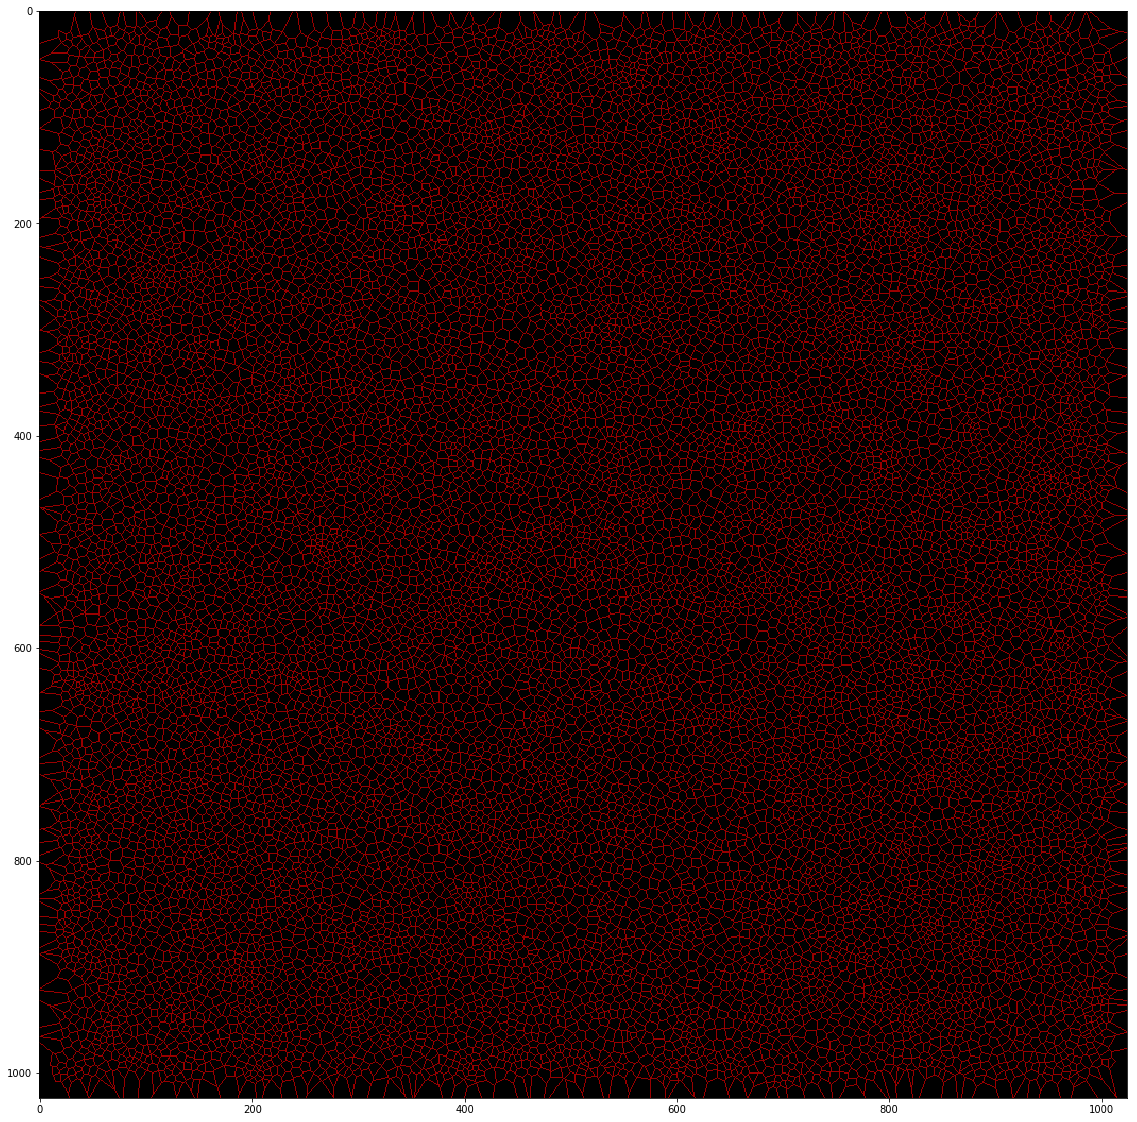

CPU times: user 2.83 s, sys: 314 ms, total: 3.14 s
Wall time: 2.74 s


In [8]:
%%time

print("Generating mesh", flush=True)
mesh = Mesh(dimensions=(MAP_SIZE, MAP_SIZE), npoints=DOTS_AMOUNT, relax_steps=2)

print("Allocating image", flush=True)
img = np.zeros((MAP_SIZE, MAP_SIZE, 3), np.uint8)

print("Drawing image", flush=True)
for i in range(len(mesh.ridge_vertices)):
    if mesh.ridge_vertices[i][0] < 0:
        continue
    coordinates = mesh.vertices[mesh.ridge_vertices[i]]
    cv2.line(img, tuple(coordinates[0].astype(int)), tuple(coordinates[1].astype(int)), (153, 0, 0), 1)

shimg(img, "mesh")

Generating plates


Drawing plates


Drawing movement vectors


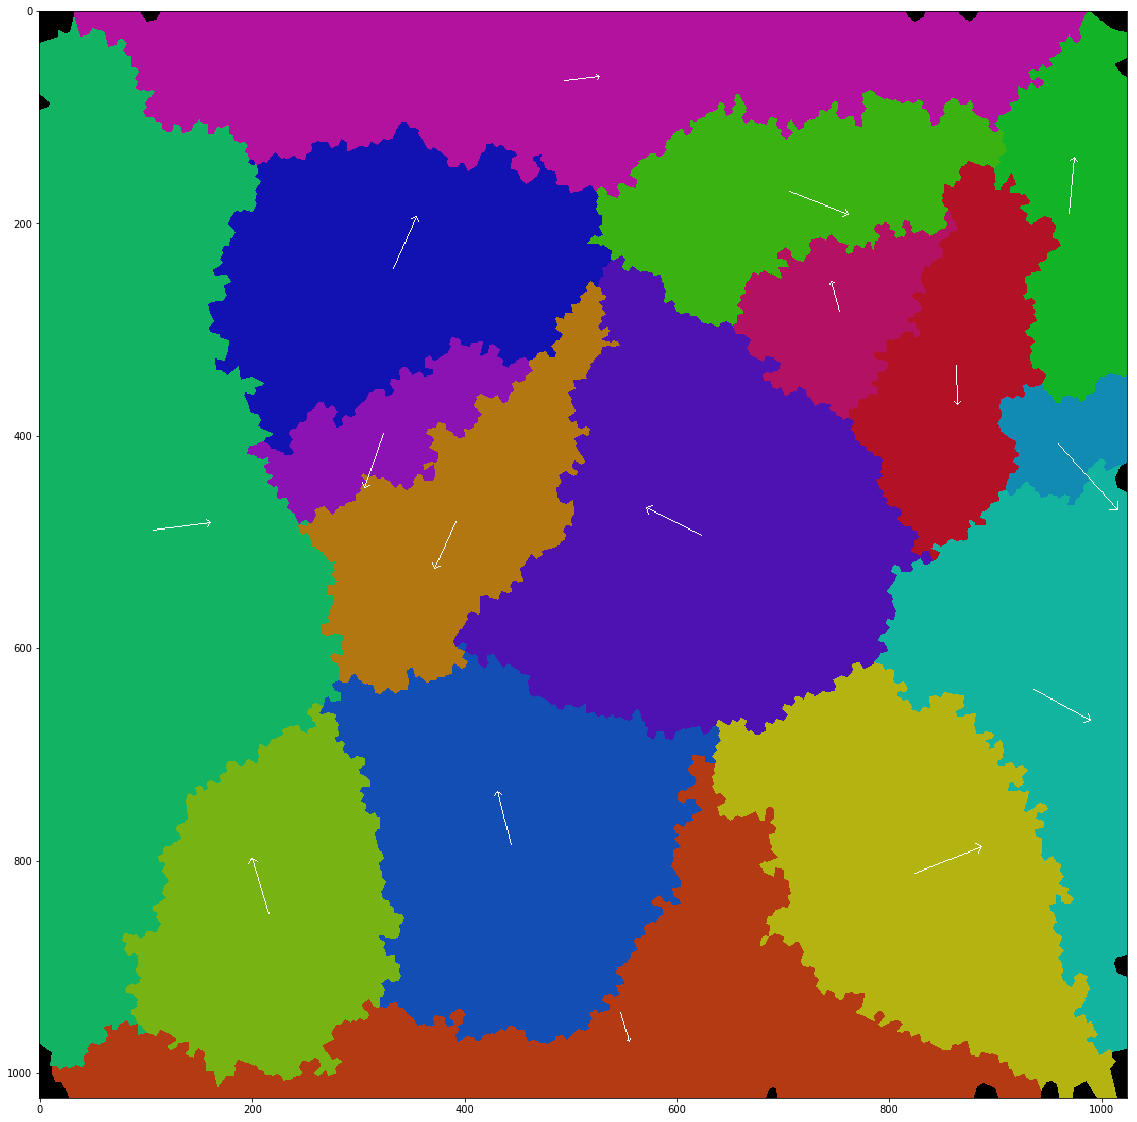

CPU times: user 1.2 s, sys: 290 ms, total: 1.49 s
Wall time: 1.1 s


In [22]:
%%time

img = np.zeros((MAP_SIZE, MAP_SIZE, 3), np.uint8)
mesh.create_noise()
geo = Geo(mesh)

print("Generating plates", flush=True)
plates = geo.create_tectonic_plates(TECTONIC_PLATES_AMOUNT)
movement = np.random.uniform(-1.0, 1.0, len(plates * 2)).reshape((len(plates), 2))

print("Drawing plates", flush=True)
for i, plate in enumerate(plates):
    (r, g, b) = tuple(c * 256 for c in hsv_to_rgb(float(i) / len(plates), 0.9, 0.7))
    for point in plate:
        if mesh.point_region[point] in mesh.infinite_regions:
            continue
        coordinates = mesh.vertices[mesh.regions[mesh.point_region[point]]]
        cv2.fillConvexPoly(img, coordinates.astype('int32'), (b, g, r))

print("Drawing movement vectors", flush=True)
for i, plate in enumerate(plates):
    arrow_scale = max(MAP_SIZE / TECTONIC_PLATES_AMOUNT, 10.0)
    vx, vy = movement[i]
    avg_x = 0.0
    avg_y = 0.0
    for p in plate:
        avg_x += mesh.points[p][0]
        avg_y += mesh.points[p][1]
    avg_x = int(avg_x / len(plate))
    avg_y = int(avg_y / len(plate))
    cv2.arrowedLine(img, (avg_x, avg_y), (avg_x + int(vx * arrow_scale), avg_y + int(vy * arrow_scale)), (255, 255, 255), 1)

shimg(img, "plates")


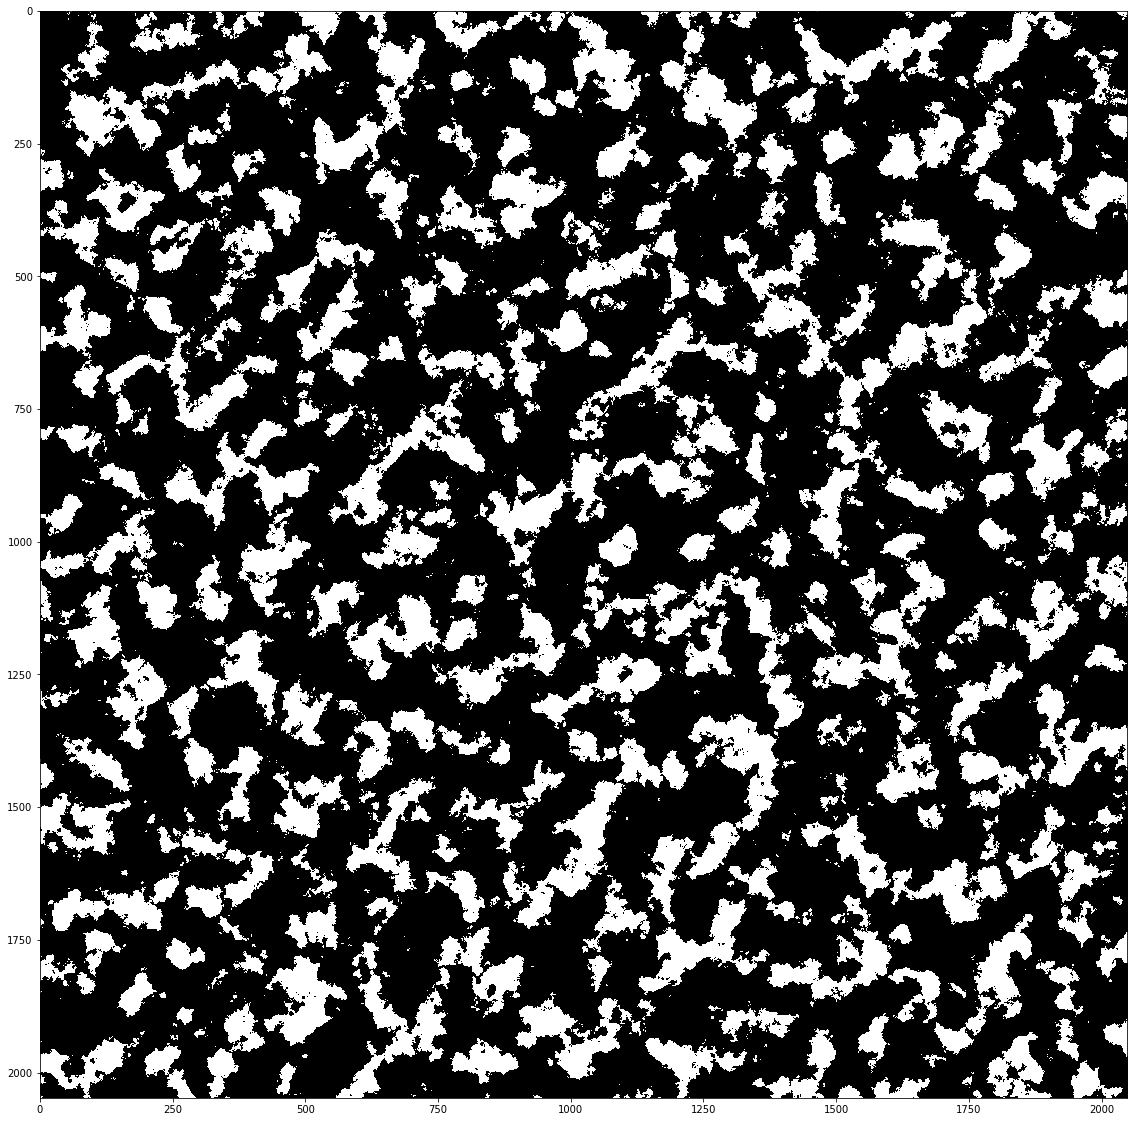

error: OpenCV(3.4.3) /io/opencv/modules/imgproc/src/color.hpp:255: error: (-2:Unspecified error) in function 'cv::CvtHelper<VScn, VDcn, VDepth, sizePolicy>::CvtHelper(cv::InputArray, cv::OutputArray, int) [with VScn = cv::Set<3, 4>; VDcn = cv::Set<3, 4>; VDepth = cv::Set<0, 2, 5>; cv::SizePolicy sizePolicy = (cv::SizePolicy)2u; cv::InputArray = const cv::_InputArray&; cv::OutputArray = const cv::_OutputArray&]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [4]:
%%time

scale = 128.0
octaves = 16
persistence = 0.6
lacunarity = 1.9
levl = 0.40

colormap = LinearSegmentedColormap(
    'TerrainCmap', {
        'red': (
            (0.00, 0.00, 0.00),
            (levl, 0.00, 1.00),
            (1.00, 1.00, 1.00),
        ),

        'green': (
            (0.00, 0.00, 0.00),
            (levl, 0.00, 1.00),
            (1.00, 1.00, 1.00),
        ),

        'blue': (
            (0.00, 0.00, 0.00),
            (levl, 0.00, 1.00),
            (1.00, 1.00, 1.00),
        ),
    })

img = np.zeros((MAP_SIZE, MAP_SIZE), np.float32)
for i in range(MAP_SIZE):
    for j in range(MAP_SIZE):
        val = noise.snoise2(i / scale,
                            j / scale,
                            octaves=octaves,
                            persistence=persistence,
                            lacunarity=lacunarity,
                            base=0)
        img[i][j] = ((val + 1) / 2.0)**2
plt.imshow(img, cmap=colormap)
plt.show()